# SDS 4481 Final Presentation 
**by Xinyue Ha**


# 1. Introduction

## 1.1 Y-variable selection and Research Goals
In this project, I am interested in exploring how education, economic and health factors relate to political outcomes at the county level. Specifically, I chose the 2016 U.S. presidential election results **(Election.Results.2016)** as my y-variable, which classifies counties based on whether the majority supported the Democratic or Republican Party.

When I was reviewing the data dictionary, I came up with three main questions:

1. **Education Factor: Does Education Shape Voting Outcomes?**

I first focus on education alone, examining whether **high school graduation rates** are associated with county-level voting outcomes. Because education plays a key role in shaping people's perceptions of society and the world around them, which may have link with their political preferences. Here I will start with a single clear predictor as a simple baseline for my analysis.

2. **Economic Factors: How Do The Economic Conditions Influence Voting?**

Then, I will incorporate some economic factors that I am interested in as key predictors, which includes **median household income** and **unemployment rate**. In addition to analyzing their individual effects, I also explore the relationship between income and unemployment, investigating how economic conditions jointly influence political outcomes.

3. **Health Factors: Are Health and Lifestyle Linked to Party Support?**

Finally, I extend the analysis to include health-related variables. I select six representative indicators of public health and lifestyle:  **poor health, adult obesity, proportion of smokers, excessive drinking, insufficient sleep, and physical inactivity**, and examine how these health factors at the county level correlate with political preferences. To deepen the analysis, I plan to employ both decision tree modeling and logistic regression to capture the relationships between education, economic and health variables and voting behavior.


## 1.2 Data Import and Checking
1. I first loaded the dataset from final_project.csv using pd.read_csv.
2. Then I printed the column names and data types to get an overview of the dataset (2715 rows and 26 colimns).
3. I used .isna().sum() to check for missing values and confirmed there were none.
4. Finally, I converted four object columns to categorical type to support modeling, keeping CountyName as object because each county is unique and not useful for modeling.

In [753]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [754]:
county_data = pd.read_csv('/Users/harrymaxx/Desktop/SDS 5481 Python /5481 Final Project/final_project.csv',
                          index_col='Row.Label')

#print(county_data.columns)
#print(county_data.dtypes)
#print(county_data.describe)
#print(county_data.isna().sum()) # All the variables show zero. 

# ... (some parts omitted for readability)

In [755]:
cat_vars = ['State.Abbreviation', 'Election.Results.2016', 'Food.Insecurity.Quintile', 'Income.Inequality.Quartile']
county_data[cat_vars] = county_data[cat_vars].astype('category')
print(county_data.dtypes)

Five-digit.FIPS.Code                   int64
State.FIPS.Code                        int64
County.FIPS.Code                       int64
State.Abbreviation                  category
CountyName                            object
Poor.Health                          float64
Election.Results.2016               category
Uninsured                            float64
Primary.Care.Physicians.Per.1000     float64
Mental.health.providers.Per.1000     float64
Adult.Obesity                        float64
Proportion.of.Smokers                float64
High.School.Graduation               float64
Insufficient.Sleep                   float64
Physical.Inactivity                  float64
Excessive.Drinking                   float64
Median.Household.Income                int64
Severe.Housing.Problems              float64
Unemployment                         float64
Food.Insecurity.Quintile            category
Income.Inequality.Quartile          category
Percent.Rural                        float64
Over.65   

## 1.3 Data Overviews
Here are brief explanations for all the variables in this dataset. The variables highlighted in red are those selected for use in our model.
<style>
table {
    background-color: white;
}
tr:nth-child(even) {
    background-color: white;
}
tr:nth-child(odd) {
    background-color: white;
}
</style>
| Variable | Description |
|:---|:---|
| **Data Identifiers** | |
| Row Label | Unique label for each row (used as row index). |
| Five-digit FIPS | Unique 5-digit identifier for each U.S. county. |
| State FIPS | Two-digit code identifying the state. |
| County FIPS | County identifier within the state. |
| <font color="red">State Abbreviation</font> | Two-letter state abbreviation. |
| <font color="red">County Name</font> | Name of the county. |
| **Outcome Variables** | |
| <font color="red">Poor Health</font> | Percentage of adults reporting fair or poor health. |
| <font color="red">Election.Results.2016</font> | Democrat or Republican receiving the most votes in the 2016. |
| **Access and Quality of Care** | |
| Uninsured | Percentage of adults without health insurance. |
| Primary Care Physicians Per 1000 | Number of primary care providers per 1,000 people. |
| Mental Health Providers Per 1000 | Number of mental health providers per 1,000 people. |
| **Social Determinants of Health - Behavioral** | |
| <font color="red">Adult Obesity</font> | Percentage of adults classified as obese. |
| <font color="red">Proportion of Smokers</font> | Percentage of adult smokers. |
| <font color="red">High School Graduation</font> | County-level high school graduation rate. |
| <font color="red">Insufficient Sleep</font> | Percentage of adults reporting less than 7 hours of sleep. |
| <font color="red">Physical Inactivity</font> | Percentage of adults not engaging in physical activity. |
| <font color="red">Excessive Drinking</font> | Percentage of adults reporting binge or heavy drinking. |


<style>
table {
    background-color: white;
}
tr:nth-child(even) {
    background-color: white;
}
tr:nth-child(odd) {
    background-color: white;
}
</style>
| Variable | Description |
|:---|:---|
| **Social Determinants of Health - Environmental** | |
| <font color="red">Median Household Income</font> | Median income of households in the county. |
| Severe Housing Problems | Percentage of households facing serious housing issues. |
| <font color="red">Unemployment</font> | Unemployment rate in the county. |
| Food Insecurity Quintile | Food insecurity level (1 = low, 5 = high). |
| Income Inequality Quartile | Income inequality level (1 = low, 4 = high). |
| **Demographic Characteristics** | |
| Percent Rural | Percentage of the population living in rural areas. |
| Over 65 | Percentage of the population aged over 65. |
| Percent Females | Percentage of the female population. |
| Life Expectancy | Average life expectancy at birth. |
| <font color="red">Population</font> | Total population of the county. |


## 1.4 Summary statistics
To begin with the analysis, I created a basic summary statistics: Summarizing by state and identifying the top 5 states and the bottom 5 states based on the proportion of Democratic-preferred counties. However, although some states in the table show 100% support for Democrats, they may have only a few counties included, which made me wonder if can we really reflect public opinion just by looking at county proportions? Maybe we should find a better way to take population into account.

To fix this issue, I checked the website "USA.gov – How the President is Elected" (https://www.usa.gov), and found that the number of electoral votes each state gets is based on its population, not its number of counties. Therefore, I created a population weighted support rate. I added up the total population of Democrat and Republican supporting counties in each state, so that it can give us a much more realistic view.

Now we can see the table shows the top 5 and bottom 5 states based on population-weighted Democrat support rates. States like DC, HI, VT, MA, and AK have 100% Democrat support by population, while states like WY, WV, OK, ND, and SD show almost complete Republican dominance. Population weighting may provide a more accurate reflection of political preferences compared to simply counting counties. However, although we explored these summary statistics for initial understanding, our main analysis still focuses on county-level predictors. Thus, we did not incorporate these state-level summaries into the final models.


In [759]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [760]:
# Count the number of counties in each state by party
state_party_counts = (county_data.groupby(['State.Abbreviation', 'Election.Results.2016'])
                    .size().unstack(fill_value=0)  # Convert party column into separate columns
)

# Compute total counties in each state
state_party_counts['Total'] = state_party_counts.sum(axis=1)

# Compute proportions
state_party_counts['Democrat_Proportion'] = state_party_counts['Democrat'] / state_party_counts['Total']
state_party_counts['Republican_Proportion'] = state_party_counts['Republican'] / state_party_counts['Total']

# Reorder columns
state_party_counts = state_party_counts[[
    'Democrat', 'Democrat_Proportion', 'Republican', 'Republican_Proportion', 'Total']]

# Sort by Democrat proportion in descending order
state_party_counts_sorted = state_party_counts.sort_values(by='Democrat_Proportion', ascending=False)


In [761]:
# Display the top 5 and bottom 5 states based on the proportion of Democratic preferred counties.
display(pd.concat([state_party_counts_sorted.head(5)]))
display(pd.concat([state_party_counts_sorted.tail(5)]))

Election.Results.2016,Democrat,Democrat_Proportion,Republican,Republican_Proportion,Total
State.Abbreviation,,,,,
AK,2,1.0,0,0.0,2
HI,4,1.0,0,0.0,4
DC,1,1.0,0,0.0,1
VT,12,1.0,0,0.0,12
MA,13,1.0,0,0.0,13


Election.Results.2016,Democrat,Democrat_Proportion,Republican,Republican_Proportion,Total
State.Abbreviation,,,,,
KS,2,0.022222,88,0.977778,90
KY,2,0.017391,113,0.982609,115
OK,0,0.000000,58,1.000000,58
WV,0,0.000000,49,1.000000,49
WY,0,0.000000,21,1.000000,21


In [762]:
# Create two boolean columns indicating whether the county voted Democrat or Republican
county_data['Democrat_Win'] = county_data['Election.Results.2016'] == 'Democrat'
county_data['Republican_Win'] = county_data['Election.Results.2016'] == 'Republican'

# Group by State and sum up the population for each party
# Calculate total population of Democrat and Republican winning counties per state
state_population_summary = county_data.groupby('State.Abbreviation').agg({
    'Population': 'sum',  # Total state population
    'Democrat_Win': lambda x: (county_data.loc[x.index, 'Population'] * x).sum(),
    'Republican_Win': lambda x: (county_data.loc[x.index, 'Population'] * x).sum()})

# Rename the columns for clarity
state_population_summary = state_population_summary.rename(columns={
    'Democrat_Win': 'Democrat_Population',
    'Republican_Win': 'Republican_Population'})

# Calculate population proportions
state_population_summary['Democrat_Proportion'] = state_population_summary['Democrat_Population'] / state_population_summary['Population']
state_population_summary['Republican_Proportion'] = state_population_summary['Republican_Population'] / state_population_summary['Population']

# Sort by Democrat proportion descending
state_population_summary_sorted = state_population_summary.sort_values(by='Democrat_Proportion', ascending=False)

In [763]:
# Display the top 5 and bottom 5 states based on population-weighted Democrat support rates.
display(pd.concat([state_population_summary_sorted.head(5)]))
display(pd.concat([state_population_summary_sorted.tail(5)]))

,Population,Democrat_Population,Republican_Population,Democrat_Proportion,Republican_Proportion
State.Abbreviation,,,,,
AK,300119,300119,0,1.0,0.0
HI,1427450,1427450,0,1.0,0.0
DC,693972,693972,0,1.0,0.0
VT,610429,610429,0,1.0,0.0
MA,6842494,6842494,0,1.0,0.0


,Population,Democrat_Population,Republican_Population,Democrat_Proportion,Republican_Proportion
State.Abbreviation,,,,,
SD,774057,19825,754232,0.025612,0.974388
ND,593858,14531,579327,0.024469,0.975531
OK,3813754,0,3813754,0.000000,1.000000
WV,1747055,0,1747055,0.000000,1.000000
WY,553653,0,553653,0.000000,1.000000


# 2. Education Factor

## 2.1 Boxplot (Education)
The boxplot shows that both Democrat and Republican majority counties have generally high high school graduation rates. And the counties voting Republican tend to have slightly higher median graduation rates. Overall, there is still a considerable overlap between these two groups, indicating that education level alone may not be a strong factor of political preference.


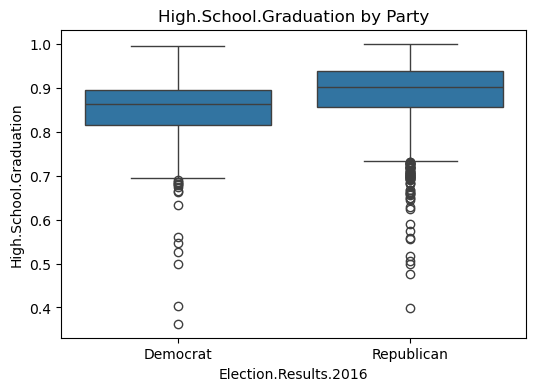

In [766]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Election.Results.2016', y='High.School.Graduation', data=county_data)
plt.title('High.School.Graduation by Party')
plt.show()

## 2.2 Tree Analysis (Education)
Next, we generated a simple decision tree using only "High School Graduation" as the predictor so there was only one importance variable. The tree showed that after splitting, most of the counties remained classified as Republican. This suggests that although education level has some predictive value, it is not strong enough to clearly separate Democrat and Republican majority counties by itself. Therefore, to gain a deeper understanding, I decided to explore the relationship between education and economic variables, and their relationship with voting outcomes in the next step.


In [768]:
# Prepare data (Education predictor)
X_education = county_data[['High.School.Graduation']]  # Only education-related predictor
y = county_data['Election.Results.2016']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_education, y_encoded, test_size=0.3, random_state=42)

# Fit a simple decision tree
tree_education = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_education.fit(X_train, y_train)

# Display variable importance
importance = pd.DataFrame({
    'Feature': ['High.School.Graduation'],
    'Importance': tree_education.feature_importances_
})
display(importance)


,Feature,Importance
0,High.School.Graduation,1.0


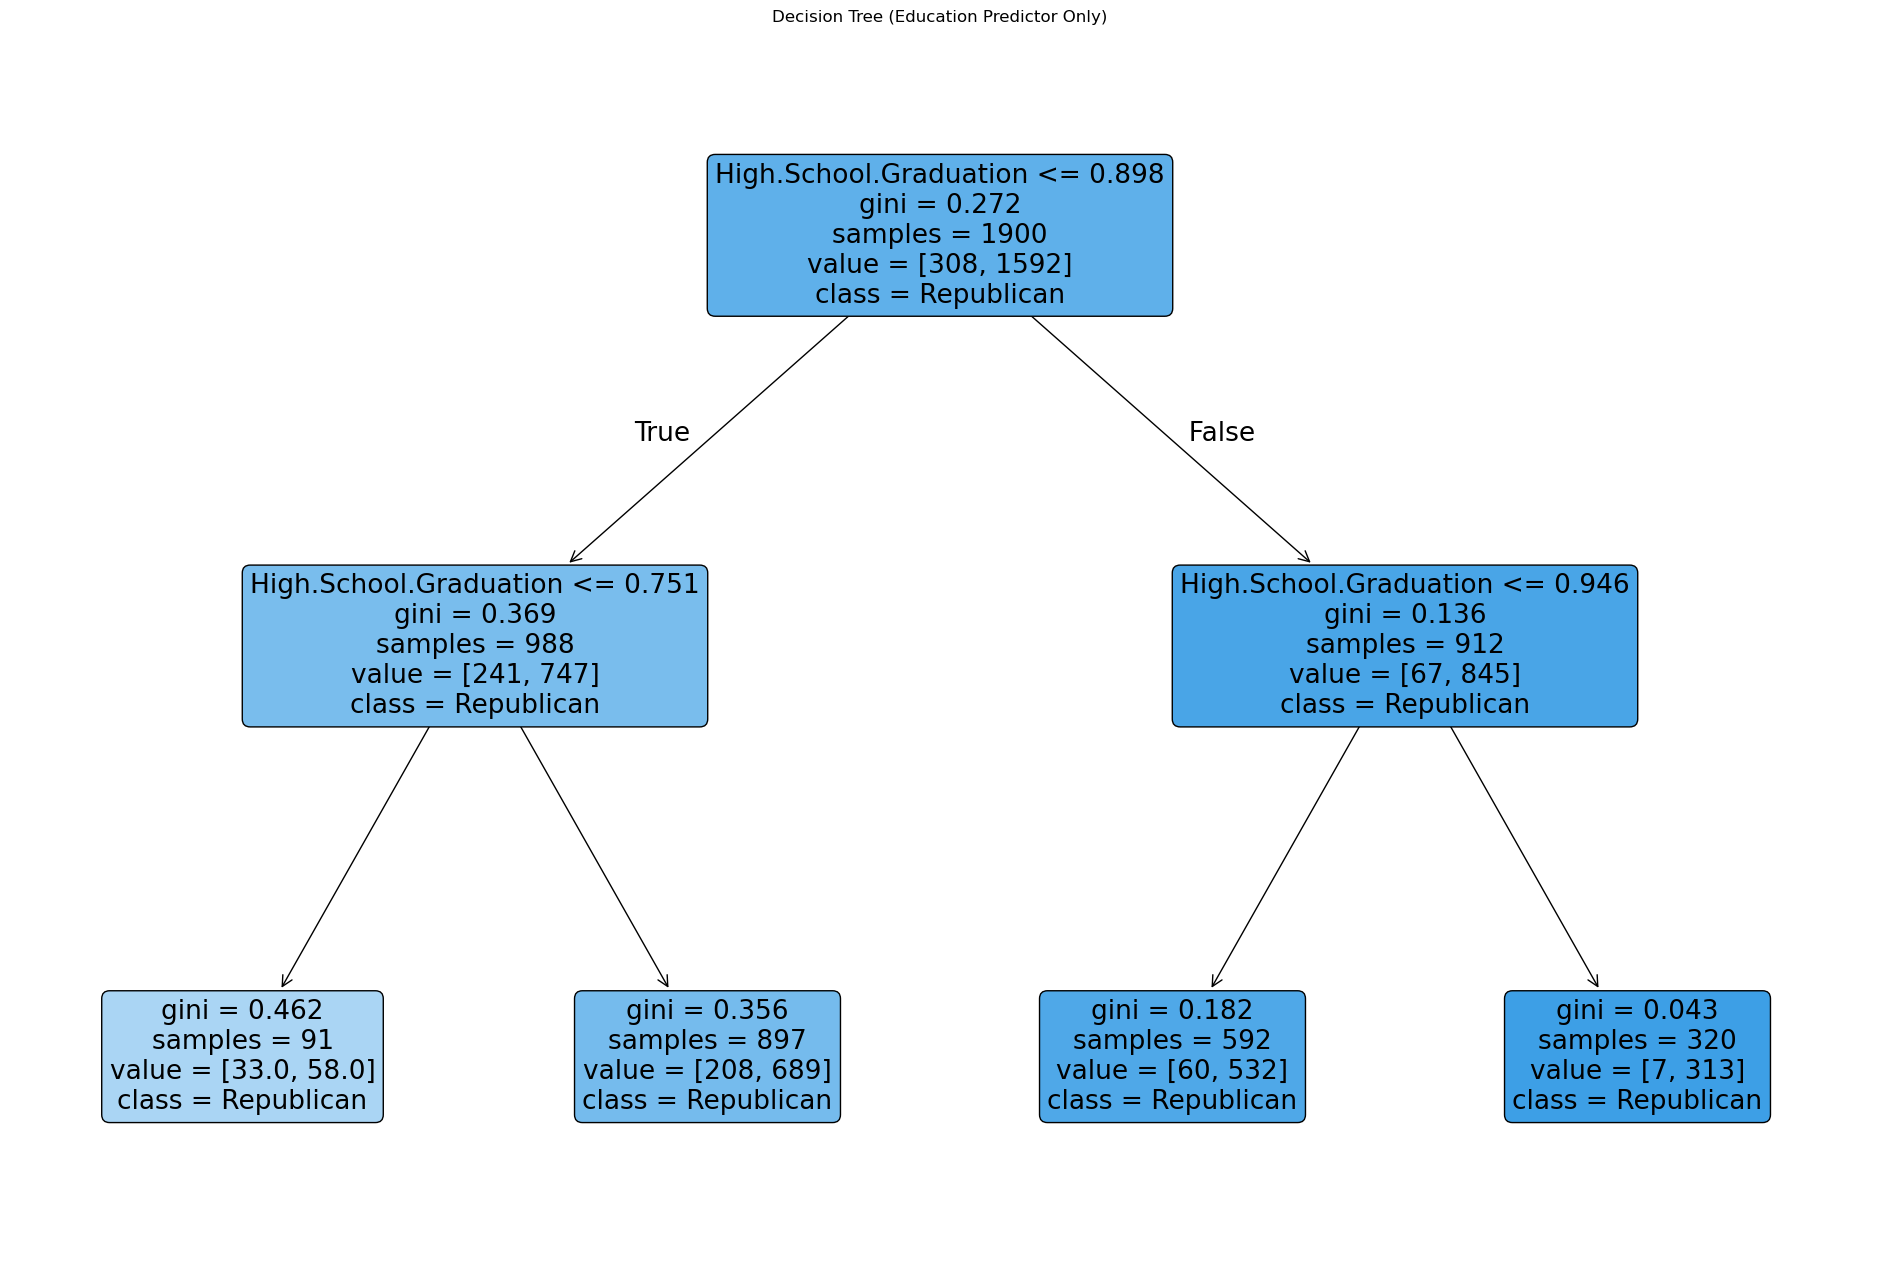

In [769]:
# Plot the decision tree
plt.figure(figsize=(24,16))
plot_tree(tree_education, feature_names=['High.School.Graduation'], class_names=le.classes_, filled=True, rounded=True)
plt.title('Decision Tree (Education Predictor Only)')
plt.show()

# 3. Economic Factors

## 3.1 Boxplots and Scatterplots (Education + Economic)
Building on our previous findings, we now add economic factors into our analysis. The boxplots show that Democrat-majority counties tend to have slightly higher median incomes and unemployment rates compared to Republican-majority counties. However, for both variables, the distributions still overlap a lot, showing that the income and unemployment alone do not clearly separate the two groups either.

We also found that income and unemployment are moderately negatively correlated (-0.436), which is consisent with our intuition: counties with higher incomes tend to have lower unemployment rates. Even though the relationships between education, income, and unemployment are weaker than expected, they still move in the expected directions.


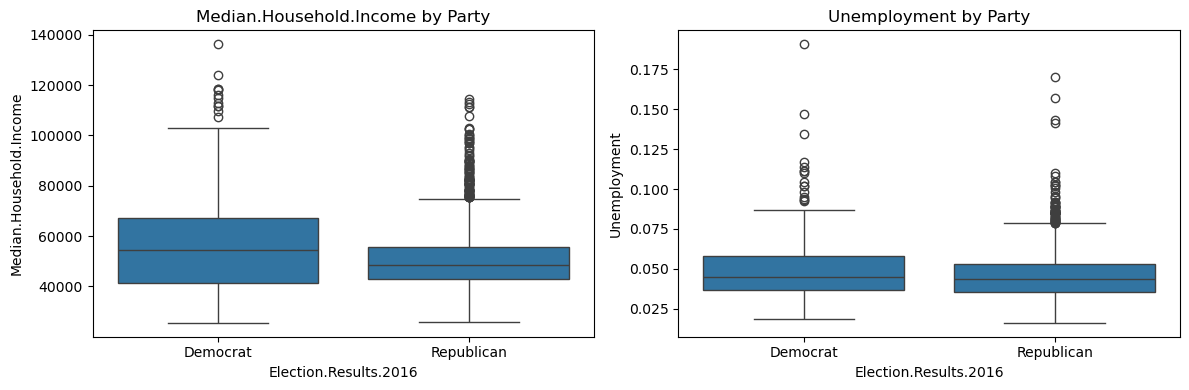

In [772]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x='Election.Results.2016', y='Median.Household.Income', data=county_data)
plt.title('Median.Household.Income by Party')

plt.subplot(1, 2, 2)
sns.boxplot(x='Election.Results.2016', y='Unemployment', data=county_data)
plt.title('Unemployment by Party')

plt.tight_layout()
plt.show()

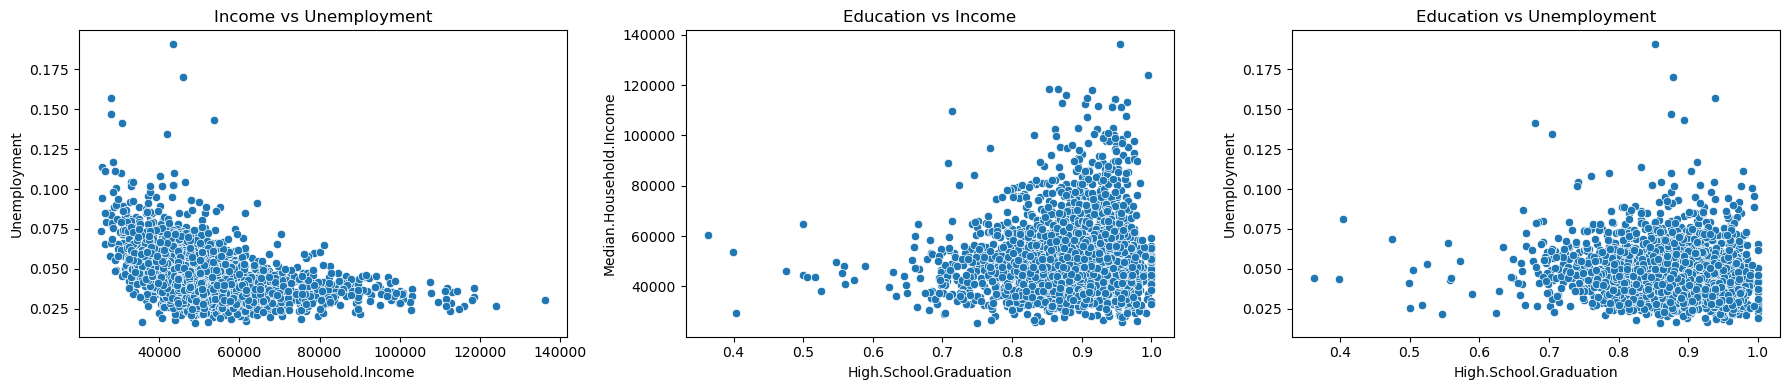

In [773]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
sns.scatterplot(x='Median.Household.Income', y='Unemployment', data=county_data)
plt.title('Income vs Unemployment')
plt.subplot(1, 3, 2)
sns.scatterplot(x='High.School.Graduation', y='Median.Household.Income', data=county_data)
plt.title('Education vs Income')
plt.subplot(1, 3, 3)
sns.scatterplot(x='High.School.Graduation', y='Unemployment', data=county_data)
plt.title('Education vs Unemployment')
plt.tight_layout()
plt.show()

In [774]:
# Correlation coefficient
correlation = county_data['Median.Household.Income'].corr(county_data['Unemployment'])
corr_edu_income = county_data['High.School.Graduation'].corr(county_data['Median.Household.Income'])
corr_edu_unemp = county_data['High.School.Graduation'].corr(county_data['Unemployment'])
print(f'Correlation between Income and Unemployment: {correlation:.3f}')
print(f'Correlation between Education and Income: {corr_edu_income:.3f}')
print(f'Correlation between Education and Unemployment: {corr_edu_unemp:.3f}')

Correlation between Income and Unemployment: -0.436
Correlation between Education and Income: 0.108
Correlation between Education and Unemployment: -0.165


## 3.2 Tree Analysis (Education + Economic)
Now we move on to the decision tree that includes both education and economic predictors. According to the feature importance scores, we can see that high school graduation rate (0.4335) and median household income (0.5665) are more important than unemployment.

Compared to the tree using the education factor alone, this combined model shows little improvement, as reflected by the decreased gini impurity in some nodes. For example, the high education and high income group shows relatively low gini (0.136 < 0.15), which shows a purer classification. However, most of the variation remains unexplained and the overall decision tree still struggles to clearly separate political preferences at the county level.

This outcome suggests that while socioeconomic conditions matter, additional factors such as health factors, might be necessary to achieve a more accurate classification.

In [776]:
X_combined = county_data[['High.School.Graduation', 'Median.Household.Income', 'Unemployment']]
y = county_data['Election.Results.2016']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.3, random_state=42)

# Fit a simple decision tree
tree_combined = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_combined.fit(X_train, y_train)

# Display variable importance
importance = pd.DataFrame({
    'Feature': X_combined.columns,
    'Importance': tree_combined.feature_importances_
}).sort_values(by='Importance', ascending=False)
display(importance)


,Feature,Importance
1,Median.Household.Income,0.566512
0,High.School.Graduation,0.433488
2,Unemployment,0.000000


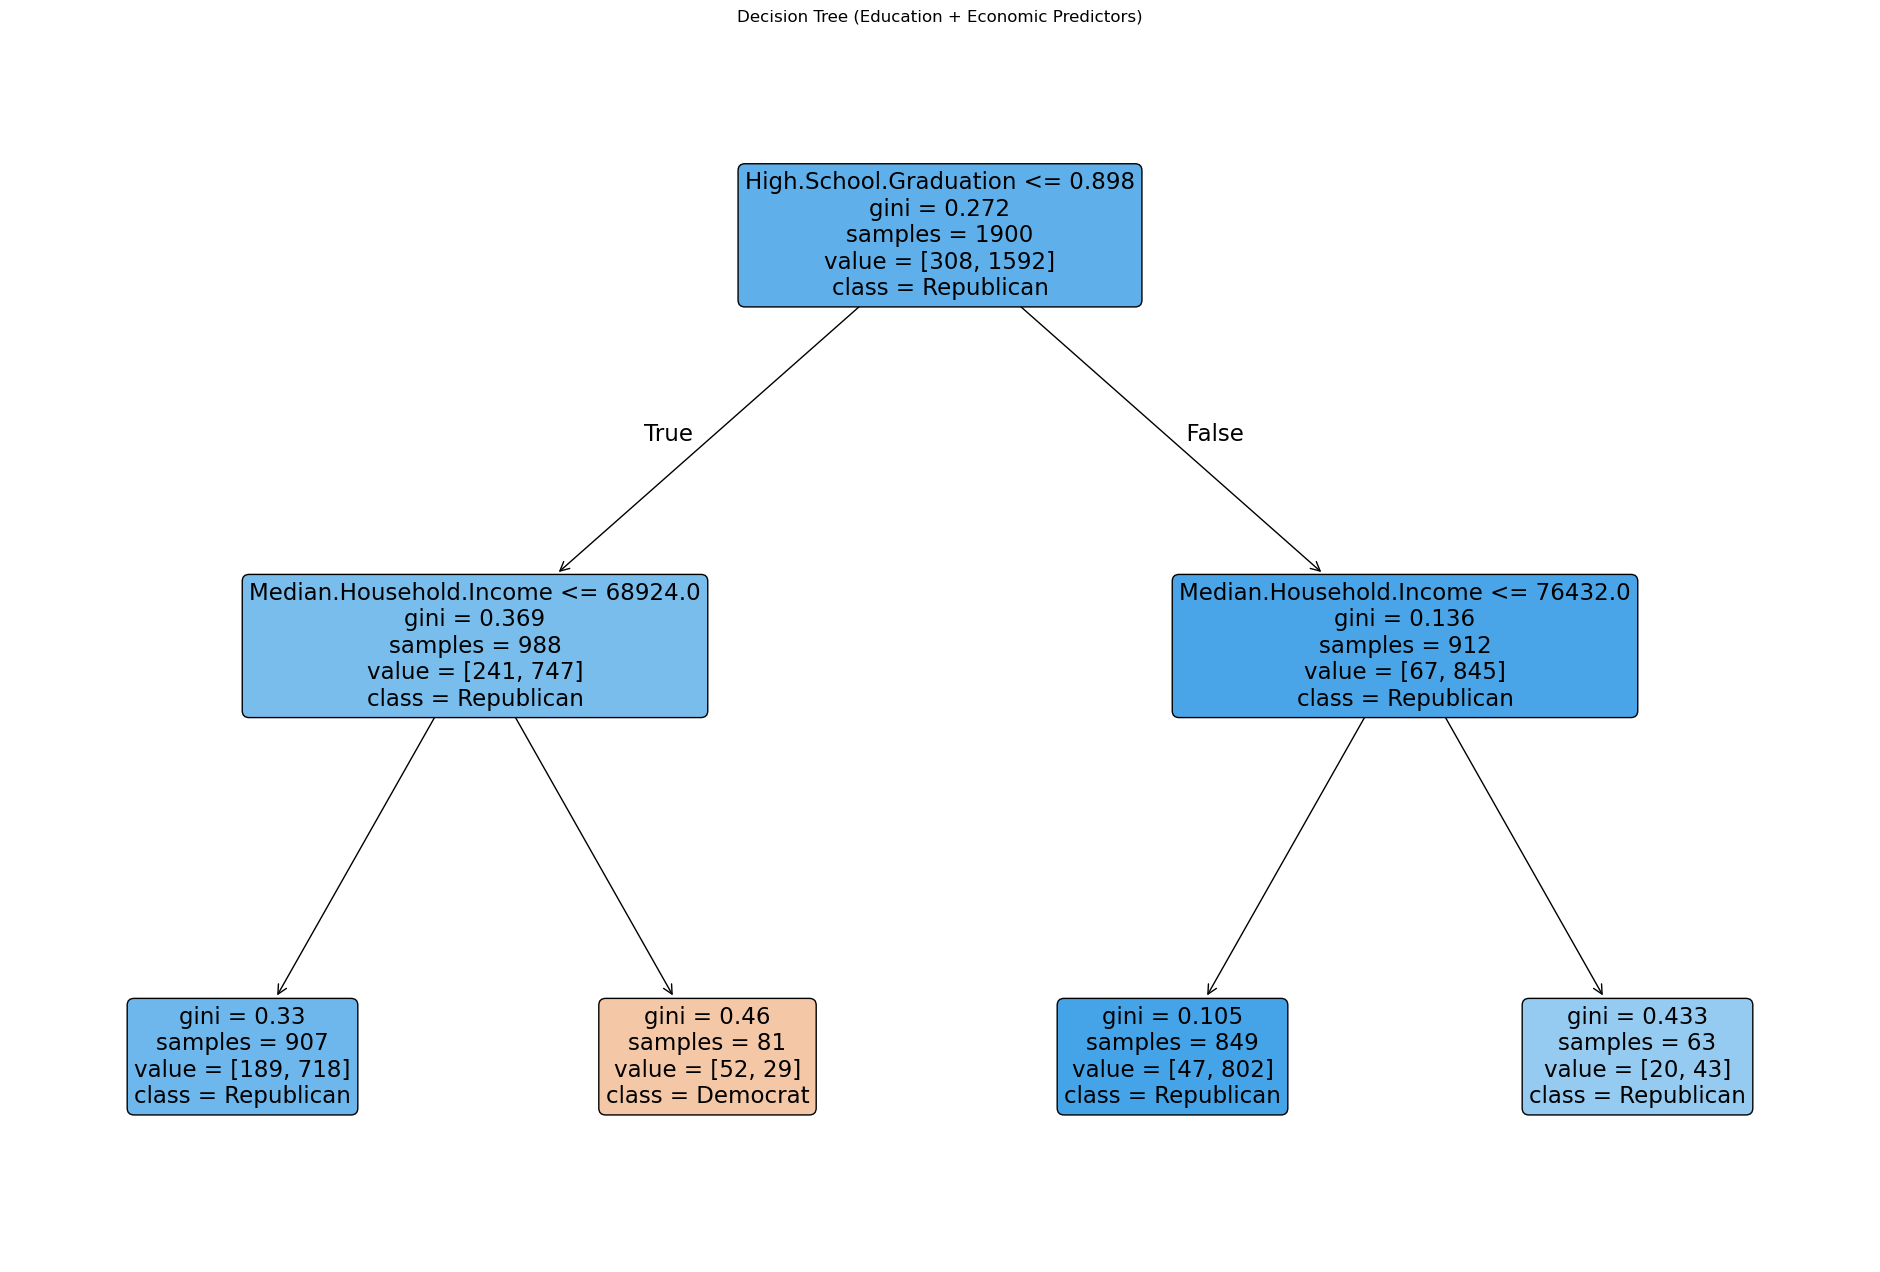

In [777]:
# Plot the decision tree
plt.figure(figsize=(24, 16))
plot_tree(tree_combined, feature_names=X_combined.columns, class_names=le.classes_, filled=True, rounded=True)
plt.title('Decision Tree (Education + Economic Predictors)')
plt.show()

# 4. Health Factor

## 4.1 Bloxplots (Health)
Now let's take a look at the health-related variables. The boxplots show that counties voting Republican tend to have slightly higher adult obesity rates and higher physical inactivity. The proportion of smokers shows only a small difference between parties and with considerable overlap. Excessive drinking and insufficient sleep do not display clear difference. 

Overall, only particularly obesity and physical inactivity show visible differences, and all of them have large overlaps. This suggests that health factors alone may not fully explain political preferences. Therefore, we will combine health, education, and economic factors together to try to build a more complete model.

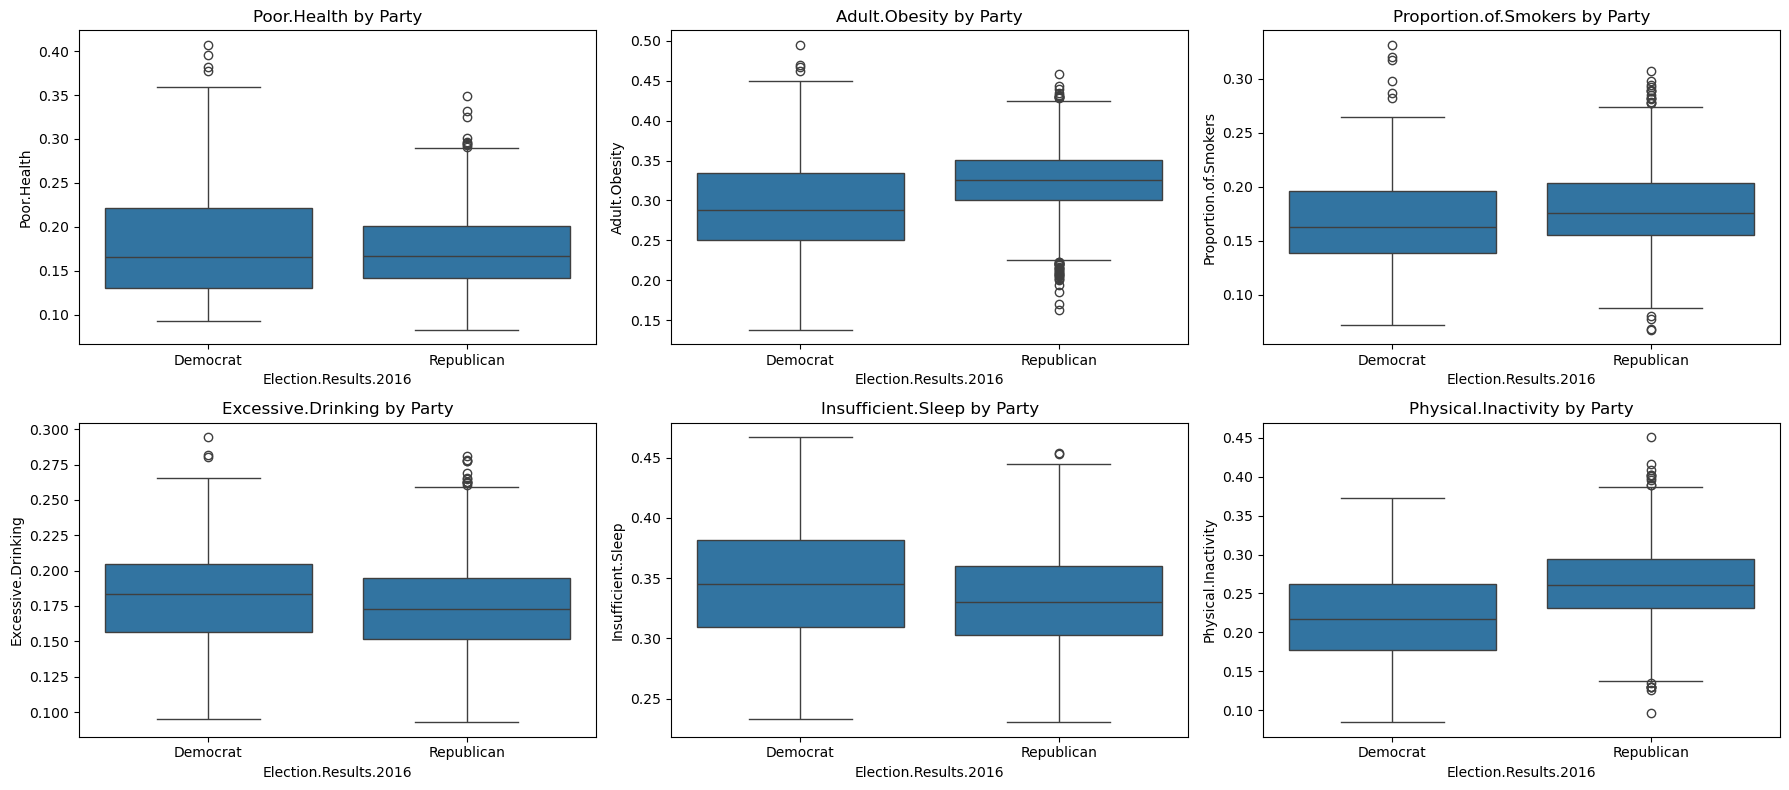

In [780]:
health_vars = ['Poor.Health', 'Adult.Obesity', 'Proportion.of.Smokers', 'Excessive.Drinking', 'Insufficient.Sleep', 'Physical.Inactivity']

plt.figure(figsize=(18, 8))
for i, var in enumerate(health_vars):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='Election.Results.2016', y=var, data=county_data)
    plt.title(f'{var} by Party')
plt.tight_layout()
plt.show()

## 4.2 Exploring Relationships Between Key Variables at County Levels

1. **Smoking vs. Drinking**

I chose Proportion of Smokers and Excessive Drinking because smoking and drinking are two lifestyle habits that often go together. The scatter plot shows a moderate positive relationship: counties with more smokers also tend to have more people who drink excessively.

2. **Physical Inactivity vs. Adult Obesity**

I chose Physical Inactivity and Adult Obesity because not getting enough exercise is a major reason why people become obese. The scatter plot shows a strong positive relationship: places with higher rates of physical inactivity usually have higher obesity rates too.

3. **Income vs. Poor Health**

I chose Median Household Income and Poor Health because a county’s economic situation can really impact people’s health. The scatter plot shows a clear negative relationship: counties with higher income levels tend to have fewer people in poor health.

4. **High School Graduation vs. Poor Health**

I chose High School Graduation Rate and Poor Health because education can make a big difference in people's health choices and their ability to get good healthcare. The scatter plot shows a general negative trend: counties with more high school graduates usually have fewer health problems, though the data points are a bit more spread out.

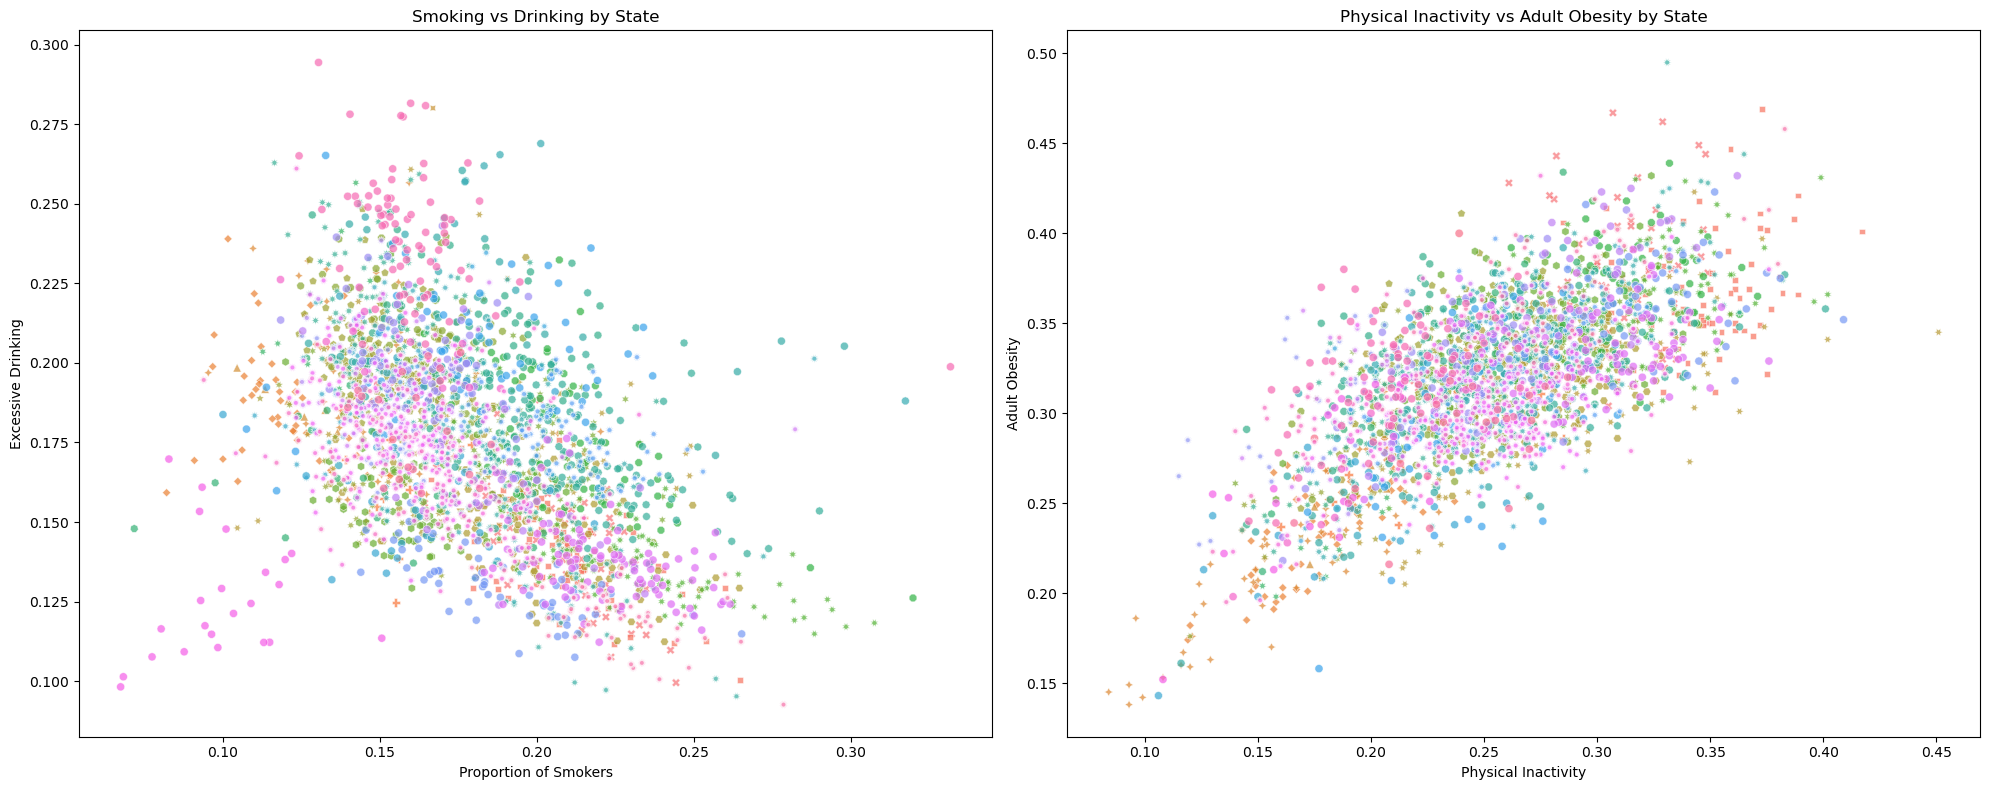

In [782]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Smoking vs Drinking
sns.scatterplot(x='Proportion.of.Smokers', y='Excessive.Drinking', data=county_data, hue='State.Abbreviation', 
                style='State.Abbreviation', ax=axes[0], alpha=0.7, legend=False)
axes[0].set_title('Smoking vs Drinking by State')
axes[0].set_xlabel('Proportion of Smokers')
axes[0].set_ylabel('Excessive Drinking')

# Physical Inactivity vs Adult Obesity
sns.scatterplot(x='Physical.Inactivity', y='Adult.Obesity', data=county_data, hue='State.Abbreviation', 
                style='State.Abbreviation', ax=axes[1], alpha=0.7, legend=False)
axes[1].set_title('Physical Inactivity vs Adult Obesity by State')
axes[1].set_xlabel('Physical Inactivity')
axes[1].set_ylabel('Adult Obesity')

plt.tight_layout()
plt.show()

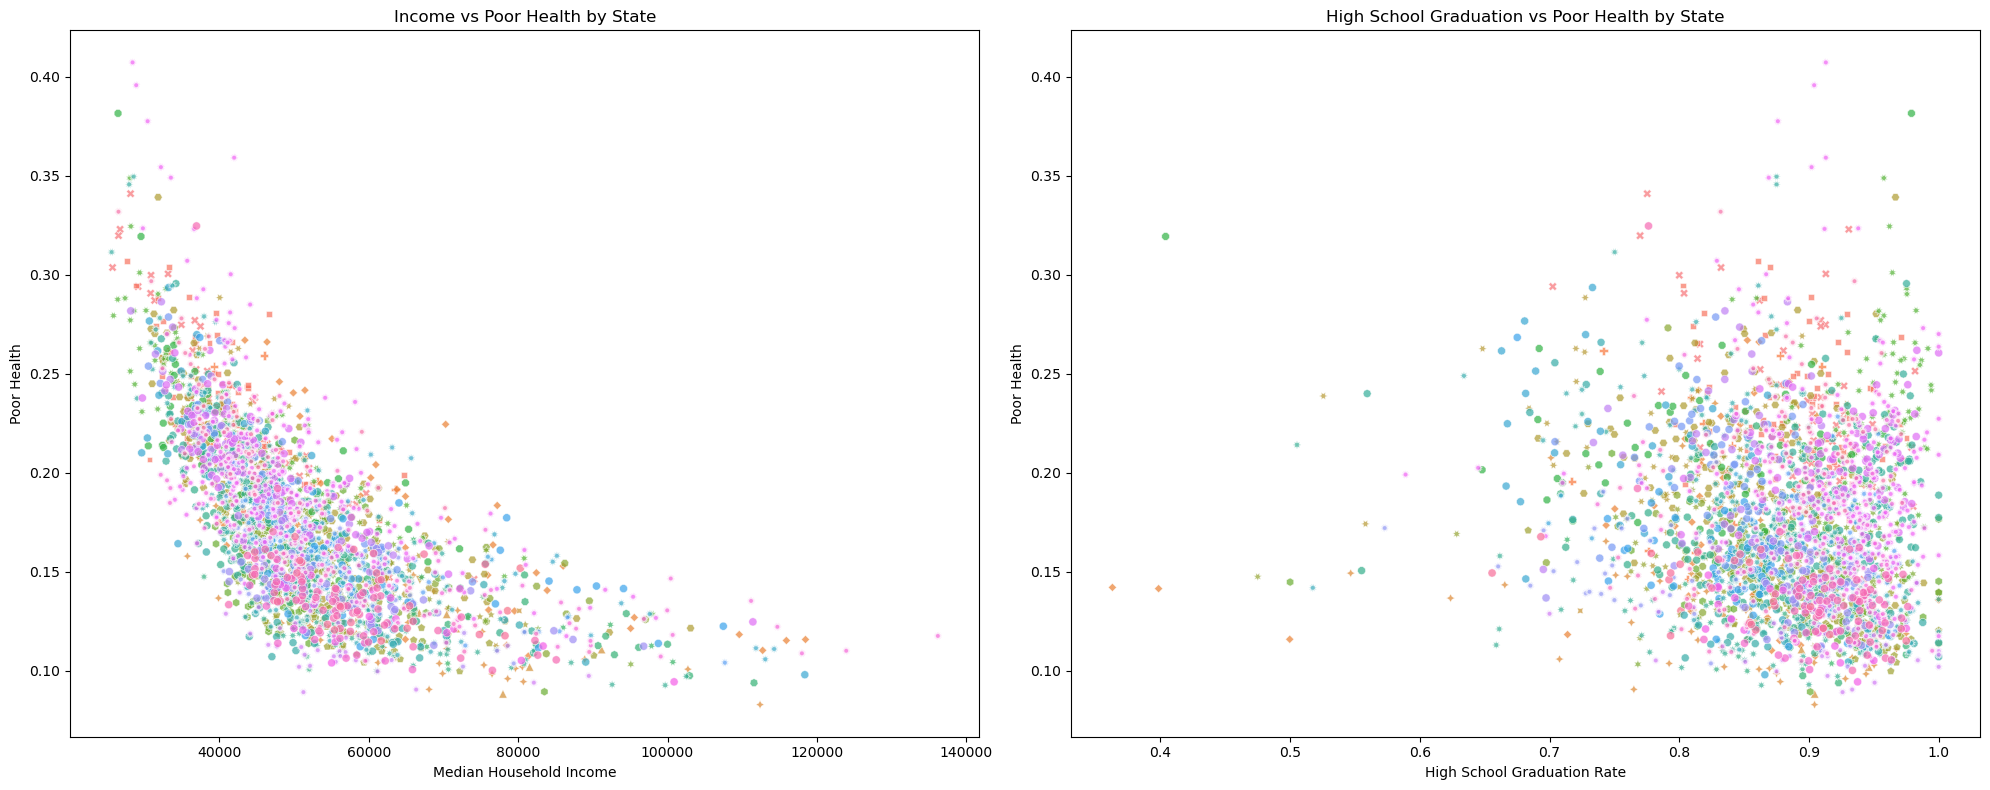

In [783]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Income vs Poor Health
sns.scatterplot(x='Median.Household.Income', y='Poor.Health', data=county_data, hue='State.Abbreviation', 
                style='State.Abbreviation', ax=axes[0], alpha=0.7, legend=False)
axes[0].set_title('Income vs Poor Health by State')
axes[0].set_xlabel('Median Household Income')
axes[0].set_ylabel('Poor Health')

# High School Graduation vs Poor Health
sns.scatterplot(x='High.School.Graduation', y='Poor.Health', data=county_data, hue='State.Abbreviation', 
                style='State.Abbreviation', ax=axes[1], alpha=0.7, legend=False)
axes[1].set_title('High School Graduation vs Poor Health by State')
axes[1].set_xlabel('High School Graduation Rate')
axes[1].set_ylabel('Poor Health')

plt.tight_layout()
plt.show()

## 4.3 Tree Analysis (Health + Education + Economic)
After adding health related factors to the model, we can see more meaningful improvements in the decision tree’s structure and predictive power. Adult Obesity becomes the most important factor, serving as the first split with a clear threshold (≤ 0.262). If obesity rates are low, Median Household Income becomes the next key factor. If obesity rates are high, Poor Health will further refine the classification.

In deeper levels, High School Graduation and Physical Inactivity also contribute to the splitting, helping to explain smaller groups.
Some of the nodes now show very low Gini impurity (e.g. Gini = 0.086 in one branch), meaning the classification is relatively pure and confident.

Here are some key findings from the tree:
* Counties with lower obesity rates and higher incomes tend to slightly favor the Democratic Party. (In the group where Adult Obesity ≤ 0.262 and Median Household Income > 60608.5, 101 out of 185 counties (about 55%) are classified as Democrat.)
* Counties with higher obesity rates and relatively better health conditions overwhelmingly favor the Republican Party. (In the group where Adult Obesity > 0.262 and Poor Health ≤ 0.278, 1498 out of 1675 counties (about 89%) are classified as Republican.)

Compared to earlier models using only education or education plus economic factors, this final one captures more detailed and realistic patterns. However, the decision tree still struggles with fully separating Democrat and Republican counties, which means that voting preferences are influenced by many complex factors beyond these 9 variables we selected.

In [785]:
# Prepare data (Health + Education + Economic predictors)
X_health_edu_econ = county_data[
    ['Poor.Health', 'Adult.Obesity', 'Proportion.of.Smokers', 'Excessive.Drinking',
     'Insufficient.Sleep', 'Physical.Inactivity',
     'High.School.Graduation', 'Median.Household.Income', 'Unemployment']
]
y = county_data['Election.Results.2016']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_health_edu_econ, y_encoded, test_size=0.3, random_state=42)

# Fit a simple decision tree
tree_health_edu_econ = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_health_edu_econ.fit(X_train, y_train)

# Display variable importance
importance = pd.DataFrame({
    'Feature': X_health_edu_econ.columns,
    'Importance': tree_health_edu_econ.feature_importances_
}).sort_values(by='Importance', ascending=False)
display(importance)

,Feature,Importance
1,Adult.Obesity,0.413905
0,Poor.Health,0.283767
6,High.School.Graduation,0.140109
7,Median.Household.Income,0.117881
5,Physical.Inactivity,0.044338
4,Insufficient.Sleep,0.000000
3,Excessive.Drinking,0.000000
2,Proportion.of.Smokers,0.000000
8,Unemployment,0.000000


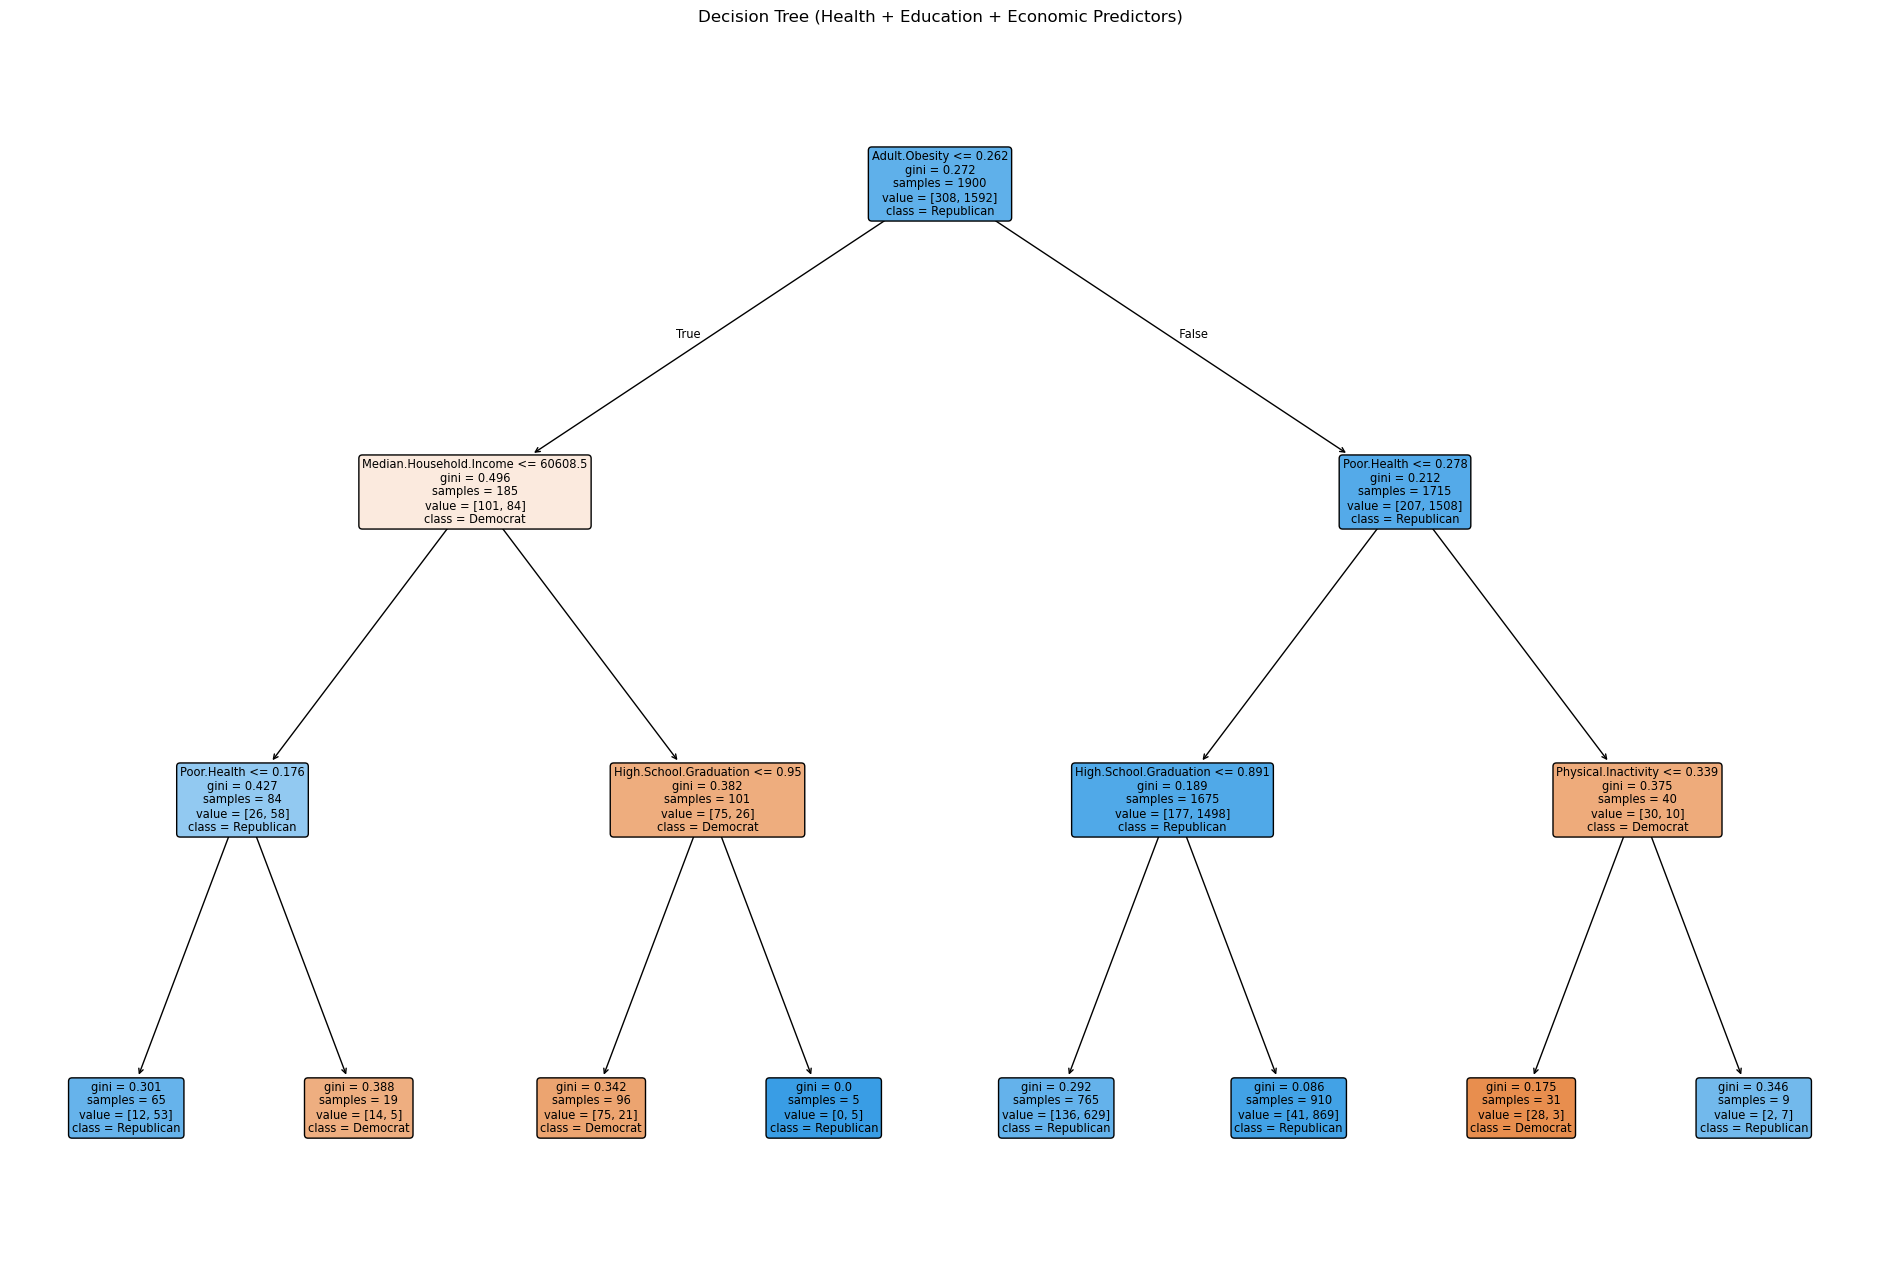

In [786]:
# Plot the decision tree
plt.figure(figsize=(24, 16))
plot_tree(tree_health_edu_econ, feature_names=X_health_edu_econ.columns, class_names=le.classes_, filled=True, rounded=True)
plt.title('Decision Tree (Health + Education + Economic Predictors)')
plt.show()

## 4.4 Logistic Regression Analysis
In addition to the decision tree model, we also fit a logistic regression model based on health, education, and economic predictors as an extra analysis. 

From the summary, the model achieves a Pseudo R-squared of approximately 0.348, indicating a moderate fit. (We need to notice here, unlike ordinary least squares regression, logistic regression uses a Pseudo R-squared to evaluate model fit, which measures improvement over a null model rather than using variance to explain.)

We can see most predictors are statistically significant, except for the unemployment rate. Key variables such as adult obesity, poor health and high school graduation rate show strong relationships with voting outcomes. To sum up, while the model captures some important trends, its predictive power still remains limited, which also suggests that other factors beyond these selected variables may influence county level voting outcomes.

In [788]:
# Prepare data
X_health_edu_econ = county_data[['Poor.Health', 'Adult.Obesity', 'Proportion.of.Smokers', 'Excessive.Drinking',
     'Insufficient.Sleep', 'Physical.Inactivity',
     'High.School.Graduation', 'Median.Household.Income', 'Unemployment']]
y = county_data['Election.Results.2016']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_health_edu_econ)

# Add intercept terms
X_scaled_with_const = sm.add_constant(X_scaled)

# Fit logistic regression
logit_model = sm.Logit(y_encoded, X_scaled_with_const)
result = logit_model.fit()


Optimization terminated successfully.
         Current function value: 0.291168
         Iterations 8


In [789]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2715
Model:                          Logit   Df Residuals:                     2705
Method:                           MLE   Df Model:                            9
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                  0.3482
Time:                        22:16:05   Log-Likelihood:                -790.52
converged:                       True   LL-Null:                       -1212.8
Covariance Type:            nonrobust   LLR p-value:                5.670e-176
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5929      0.097     26.853      0.000       2.404       2.782
x1            -1.2206      0.122    -10.005      0.000      -1.460      -0.981
x2             0.3409      0.093      3.675      0.0

# 5. Conclusions
1. **Education Factor: Does Education Shape Voting Outcomes?**

Our analysis shows that education alone (high school graduation rates) has little predictive value for voting outcomes. Counties with lower graduation rates tend to show higher Republican support. However, it is still not strong enough to clearly separate political preferences.

2. **Economic Factors: How Do the Economic Conditions Influence Voting?**

Adding economic factors like median household income and unemployment improves the model slightly. Higher income levels are generally associated with more Democratic party, but the power of predictivity is moderate. Notably, unemployment does not have a strong significance in the model.

3. **Health Factors: Are Health and Lifestyle Linked to Party Support?**

Incorporating health factors significantly improves the model's ability to distinguish counties preference. Adult obesity and poor health emerge as the most critical predictors. The counties with higher income and low physical inactivity tend to favor Democrats, while the counties with worse health indicators, such as higher obesity and higher physical inactivity are more likely to support Republicans.

# 6. Suggestions for further research

1. Select more variable from "Access and Quality of Care" and "Social Determinants of Health - Environmental" to enrich the feature set and add more dimensions to the analysis.
2. Incorporate population weighting where our earlier summary statistics showed, although not used in this project. This may help us better reflect real election mechanisms.
3. Get more data and verify results form new time periods.
4. Use more advanced models like random forests to improve prediction accuracy.
5. Try to apply causal inference methods to better understand the driving forces behind voting behavior.